# Evaluate the Effect of Temperature
We can choose different temperature for MD sampling, which has an effect of the energy of the structures created.
Higher temperature $\rightarrow$ higher energy.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from pathlib import Path
import pandas as pd
import utils
import json

## Get the runs
We want the runs named `ttm_md-1000_thr-*`

In [2]:
runs = list(Path('../prod-runs/').glob('ttm_md-3000_thr-0.001*'))
print(f'Found {len(runs)} runs')

Found 11 runs


Make sure training parameters for the network were the same

In [3]:
params = json.loads((runs[0] / 'final-model' / 'params.json').read_text())
for p in ['run_dir', 'overwrite']:
    params.pop(p)
for run in runs:
    duplicates = json.loads((run / 'duplicates.json').read_text())
    for dup in duplicates:
        dup = Path(dup)
        my_params = json.loads((dup / 'final-model' / 'params.json').read_text())
        for p in ['run_dir', 'overwrite']:
            my_params.pop(p)
        assert my_params == params, f'{dup} is different than {runs[0]}. {my_params} != {params}'

## Measure the Errors on a Hold-out Set
Get the errors for each network in force and energy for a set of structures produced by running molecular dynamics with TTM.

In [4]:
data = utils.assess_against_holdout(runs, ['dynamics_temp']).sort_values('dynamics_temp')

We now have the errors and for each error tolerance

In [5]:
data

,dynamics_temp,n_duplicates,energy_error_per_atom-mean,energy_error_per_atom-sem,force_rmsd-mean,force_rmsd-sem,energy_error_per_atom-init-mean,energy_error_per_atom-init-sem,force_rmsd-init-mean,force_rmsd-init-sem
7,50.0,1,0.465706,0.023245,0.166156,0.003102,0.611805,0.025899,0.295862,0.007720
8,100.0,1,0.466565,0.021347,0.163516,0.003130,0.611805,0.025899,0.295862,0.007720
0,200.0,2,0.483536,0.017019,0.154224,0.002111,0.611805,0.018236,0.295862,0.005436
4,300.0,1,0.513566,0.023117,0.141537,0.003034,0.611805,0.025899,0.295862,0.007720
6,400.0,1,0.527109,0.025014,0.139018,0.003069,0.611804,0.025899,0.295861,0.007720
1,500.0,2,0.496435,0.015670,0.150502,0.001935,0.611805,0.018236,0.295862,0.005436
3,600.0,1,0.430360,0.026365,0.148872,0.002832,0.611805,0.025899,0.295862,0.007720
5,700.0,1,0.492297,0.029514,0.131481,0.004013,0.611805,0.025899,0.295862,0.007720
9,800.0,1,0.457058,0.024996,0.146616,0.003193,0.611805,0.025899,0.295862,0.007720
10,900.0,1,0.470590,0.027508,0.150816,0.003073,0.611805,0.025899,0.295862,0.007720


Make a figure

Text(0.5, 0, 'MD Temperature')

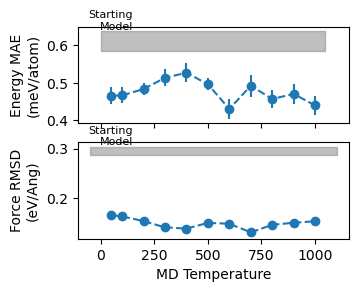

In [6]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(3.5, 2.75))

#axs[0].set_xlim([0, 21])
for ax, t in zip(axs, ['energy_error_per_atom', 'force_rmsd']):
    # Plot the initial model
    ax.errorbar(data['dynamics_temp'], data[f'{t}-mean'], fmt='--o', yerr=data[f'{t}-sem'])
    
    # Plot the initial model
    row = data.iloc[0]
    ax.fill_between(ax.get_xlim(),
                    y1=row[f'{t}-init-mean'] + row[f'{t}-init-sem'],
                    y2=row[f'{t}-init-mean'] - row[f'{t}-init-sem'],
                   color='gray', alpha=0.5)
    ax.text(150, row[f'{t}-init-mean'] + row[f'{t}-init-sem'], 'Starting\nModel',
           ha='right', va='bottom', fontsize=8)
    
axs[0].set_ylabel('Energy MAE\n(meV/atom)')
axs[1].set_ylabel('Force RMSD\n(eV/Ang)')
axs[-1].set_xlabel('MD Temperature')

Lower temperatures seem to give us better agreement with energies, higher temperature with forces. Not sure why, but at least the effect isn't huge.

## Evaluate suitability for basin hopping
We ran MCTBP with each potential for 100 steps then evaluated the energy of the minima it proposed using TTM. 
We measure the performance of the model based on a few different metrics:
- Energy and Force error between ML and TTM for the proposed minima to measure the quality of the potential for these structures.
- Maximum force for the proposed structure, as computed with TTM. A measure of how close to the relaxed geometry we are
- Ranking performance: Whether the minima ordered by energy via ML is close to the ranking via TTM. 

In [7]:
data = utils.assess_from_mctbp_runs(runs, ['dynamics_temp']).sort_values('dynamics_temp')

Summarize all runs

In [8]:
data

,dynamics_temp,n_duplicates,number_sampled,energy_error-mean,energy_error-sem,force_error-mean,force_error-sem,max_force-mean,max_force-sem,tau-mean,tau-sem
7,50.0,1,1611,49.160678,1.463861,5.654162,0.109387,2.737692,0.059035,0.499351,0.047977
8,100.0,1,1323,23.979775,0.898778,3.949812,0.101795,1.879957,0.055739,0.360029,0.083211
0,200.0,2,2606,40.562289,1.115243,5.347366,0.100018,2.623681,0.052442,0.264983,0.070028
4,300.0,1,1540,33.545950,0.934974,4.779817,0.106228,2.364543,0.055548,0.541316,0.042616
6,400.0,1,1548,38.769296,1.074239,5.233631,0.102344,2.703477,0.053723,0.431588,0.066634
1,500.0,2,2556,36.075195,1.054133,5.182968,0.098045,2.749347,0.057874,0.360685,0.063243
3,600.0,1,1611,30.662288,0.736356,4.959483,0.093110,2.585641,0.052334,0.522775,0.053147
5,700.0,1,1549,33.891357,1.010176,4.672820,0.094777,2.483550,0.054640,0.506966,0.070095
9,800.0,1,1124,69.841052,2.891307,6.736836,0.265428,3.129231,0.159457,-0.093123,0.086771
10,900.0,1,1093,53.131719,2.406825,8.499142,1.023737,4.836028,0.722844,0.154700,0.087967


Plot the errors

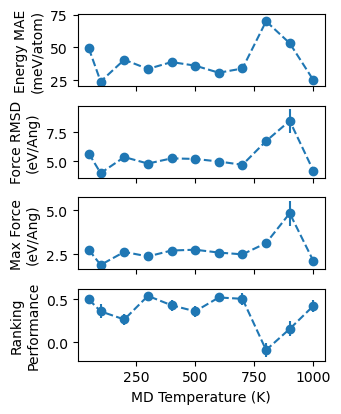

In [9]:
fig, axs = plt.subplots(4, 1, sharex=True, figsize=(3.5, 4.25))

for ax, t in zip(axs, ['energy_error', 'force_error', 'max_force', 'tau']):
    ax.errorbar(data['dynamics_temp'], data[f'{t}-mean'], fmt='--o', yerr=data[f'{t}-sem'])
    
axs[0].set_ylabel('Energy MAE\n(meV/atom)')
axs[1].set_ylabel('Force RMSD\n(eV/Ang)')
axs[2].set_ylabel('Max Force\n(eV/Ang)')
axs[3].set_ylabel('Ranking\nPerformance')
axs[-1].set_xlabel('MD Temperature (K)')

fig.tight_layout()

The MCTBP performance increases with MD run temperature. Seems we need those higher-energy configurations to get the relaxations correct.